# Задача 2. Реализация обхода в ширину из нескольких стартовых вершин (Multiple-Source BFS)

Установим библиотеку `python-graphblas` и необходимые зависимости:

In [ ]:
!pip install -q python-graphblas[default]
!pip install -q metagraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 3.6 MB/s eta 0:00:00


Подключим все необходимые для работы библиотеки:

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread

import networkx as nx
import matplotlib.pyplot as plt

Считаем разреженную матрицу, предварительно скачанную с сайта SuiteSparce Matrix Collection https://sparse.tamu.edu/:

In [ ]:
M = mmread('/content/karate.mtx')
M

"M_0"      nvals  nrows  ncols  dtype     format
gb.Matrix    156     34     34   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9   ...   24   25   26   27  \
0        1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0       ...                       
1   1.0       1.0  1.0                 1.0            ...                       
2   1.0  1.0       1.0                 1.0  1.0  1.0  ...                 1.0   
3   1.0  1.0  1.0                      1.0            ...                       
4   1.0                           1.0                 ...                       
5   1.0                           1.0                 ...                       
6   1.0                 1.0  1.0                      ...                       
7   1.0  1.0  1.0  1.0                                ...                       
8   1.0       1.0                                     ...                       
9             1.0                                     ...                       
10  1.0                 1.0  1.0                      ...                       
11  1.0                                               ...                       
12  1.0            1.0                                ...                       
13  1.0  1.0  1.0  1.0                                ...                       
14                                                    ...                       
15                                                    ...                       
16                           1.0  1.0                 ...                       
17  1.0  1.0                                          ...                       
18                                                    ...                       
19  1.0  1.0                                          ...                       
20                                                    ...                       
21  1.0  1.0                                          ...                       
22                                                    ...                       
23                                                    ...       1.0       1.0   
24                                                    ...       1.0       1.0   
25                                                    ...  1.0                  
26                                                    ...                       
27            1.0                                     ...  1.0                  
28            1.0                                     ...                       
29                                                    ...            1.0        
30       1.0                                1.0       ...                       
31  1.0                                               ...  1.0  1.0             
32            1.0                           1.0       ...                       
33                                          1.0  1.0  ...            1.0  1.0   

     28   29   30   31   32   33  
0                  1.0            
1             1.0                 
2   1.0                 1.0       
3                                 
4                                 
5                                 
6                                 
7                                 
8             1.0       1.0  1.0  
9                            1.0  
10                                
11                                
12                                
13                           1.0  
14                      1.0  1.0  
15                      1.0  1.0  
16                                
17                                
18                      1.0  1.0  
19                           1.0  
20                      1.0  1.0  
21                                
22                      1.0  1.0  
23       1.0            1.0  1.0  
24                 1.0            
25                 1.0            
26       1.0                 1.0  
27                           1.0  
28

Визуализируем матрицу в виде графа:

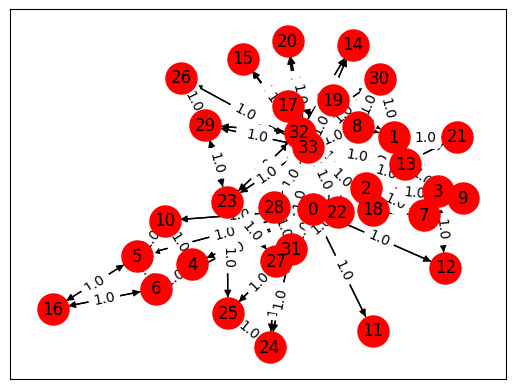

In [ ]:
gb.viz.draw(M)

Проверим, что граф является неориентированным. Чтобы проверить, что граф неориентированный, важно убедиться, что его матрица смежности симметрична. Матрица смежности неориентированного графа является симметричной, если каждый её элемент $A[i][j]$ равен элементу $A[j][i]$. Это означает, что для каждого ребра между вершинами $i$ и $j$ в обратном направлении от $j$ к $i$ существует ребро с тем же весом.

In [ ]:
def is_symmetric_gb(matrix):
    # Создаем новую матрицу как транспонированную копию исходной
    transpose = matrix.T.new()
    # Сравниваем исходную матрицу и её транспонированную версию
    return matrix.isequal(transpose)

In [ ]:
is_symmetric_gb(M)

True

1. Используя `python-graphblas` реализовать функцию обхода ориентированного графа (`MSBFS-Levels`) в ширину из нескольких заданных стартовых вершин.
 - Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
 - Функция возвращает массив пар: стартовая вершина, и массив (`levels`), где для каждой вершины указано, на каком уровне она достижима из этой стартовой. Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.

In [ ]:
def msbfs_levels(graph: Matrix, start_vertices: list):
    # Количества вершин в графе
    num_vertices = graph.nrows
    # Создание матрицы для хранения уровней
    levels_matrix = Matrix(int, len(start_vertices), num_vertices)
    # Создание матрицы для отслеживания текущего фронтира
    frontier = Matrix(int, len(start_vertices), num_vertices)

    # Инициализация фронтира для каждой стартовой вершины
    for idx, start_vertex in enumerate(start_vertices):
        frontier[idx, start_vertex] = True

    # Создание вектора для отслеживания активных фронтиров
    active = Vector(bool, len(start_vertices))
    # Установка начального уровня
    current_level = 0

    while True:
        # Присвоение текущего уровня фронтиру
        levels_matrix(frontier.V) << current_level
        # Обновление фронтира с использованием матрично-векторного умножения и исключение уже посещенных вершин
        frontier(~levels_matrix.S, replace=True) << frontier.mxm(graph, semiring.lor_land)
        # Объединение всех фронтиров для проверки активности
        active << frontier.reduce_rowwise(monoid.lor)
        current_level += 1
        if active.nvals == 0:
            break

    results = []
    for i, start_vertex in enumerate(start_vertices):
        # Инициализация списка уровней значением -1 для всех вершин
        levels = [-1] * num_vertices
        # Для каждой вершины в графе
        for j in range(num_vertices):
          # Получаем уровень из матрицы уровней
            value = levels_matrix[i, j].value
            # Если уровень существует или это стартовая вершина
            if value is not None or j == start_vertex:
                # Присвоение уровня, если вершина достижима
                levels[j] = value if value is not None else 0
        # Добавление результатов для каждой стартовой вершины в список
        results.append((start_vertex, levels))

    return results

In [ ]:
start_vertices = np.array([0, 1, 2, 3])
results = msbfs_levels(M, start_vertices)
print(results)

[(0, [0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 3, 2, 1, 3, 1, 3, 1, 3, 3, 2, 2, 3, 2, 2, 3, 2, 1, 2, 2]), (1, [1, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2]), (2, [1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 2, 2, 2, 1, 2]), (3, [1, 1, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2])]


2. Используя `python-graphblas` реализовать функцию обхода ориентированного графа (`MSBFS-Parents`) в ширину из нескольких заданных стартовых вершин.
 - Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
 - Функция возвращает массив пар: стартовая вершина, и массив (`parents`), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее.

In [ ]:
def msbfs_parents(graph: Matrix, start_vertices: list):
    # Получение количества вершин в графе
    num_vertices = graph.nrows
    # Вектор индексов вершин
    vertex_indices = Vector(dtypes.UINT64, num_vertices)
    # Построение индекса вершин
    vertex_indices.build(range(num_vertices), range(num_vertices))
    # Список для хранения результатов
    results = []

    for start_vertex in start_vertices:
        # Вектор для хранения родителей вершин
        parents = Vector(dtypes.INT64, num_vertices)
        # Установка родителя начальной вершины в -1
        parents[start_vertex] = -1
        # Вектор для текущего фронтира
        current_frontier = Vector(dtypes.INT64, num_vertices)
        # Инициализация фронтира начальной вершиной
        current_frontier[start_vertex] = 1

        while current_frontier.nvals > 0:
            # Обновление фронтира с индексами вершин
            current_frontier << vertex_indices.ewise_mult(current_frontier, binary.first)
            # Обновление фронтира и исключение посещенных вершин
            current_frontier(~parents.S, replace=True) << current_frontier.vxm(graph, semiring.min_first)
            # Обновление родителей вершин
            parents(binary.plus) << current_frontier

        # Формирование списка родителей для текущей стартовой вершины
        parents_list = [parents.get(i, default=-2) for i in range(num_vertices)]
        # Добавление результатов в список
        results.append((start_vertex, parents_list))
    return results

In [ ]:
start_vertices = np.array([0, 1, 2, 3])
results = msbfs_parents(M, start_vertices)
print(results)

[(0, [-1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 32, 32, 5, 0, 32, 0, 32, 0, 32, 25, 31, 31, 33, 2, 2, 32, 1, 0, 2, 8]), (1, [1, -1, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 32, 32, 5, 1, 32, 1, 32, 1, 32, 27, 27, 31, 33, 2, 2, 32, 1, 0, 2, 13]), (2, [2, 2, -1, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 32, 32, 5, 0, 32, 0, 32, 0, 32, 27, 27, 23, 29, 2, 2, 32, 1, 0, 2, 8]), (3, [3, 3, 3, -1, 0, 0, 0, 3, 0, 2, 0, 0, 3, 3, 32, 32, 5, 0, 32, 0, 32, 0, 32, 27, 27, 31, 33, 2, 2, 32, 1, 0, 2, 13])]


3. Добавим тесты для проверки корректности полученных реализаций.

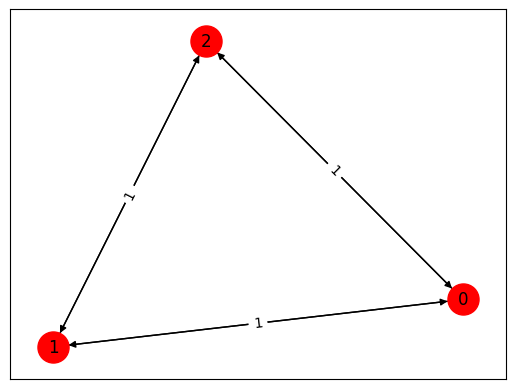

In [12]:
M1 = gb.Matrix.from_coo(
    [0, 0, 1, 1, 2, 2],
    [1, 2, 0, 2, 0, 1],
    [1, 1, 1, 1, 1, 1],
    nrows=3,
    ncols=3
)
gb.viz.draw(M1)

Результат должен представлять собой список кортежей, где каждый кортеж содержит стартовую вершину и список уровней для всех вершин графа:

**1. (0, [0, 1, 1])**

*Для стартовой вершины 0:*
- Уровень вершины 0: 0 (начальная вершина).
- Уровень вершины 1: 1 (находится на расстоянии 1 ребра от вершины 0).
- Уровень вершины 2: 1 (находится на расстоянии 1 ребра от вершины 0).


**2. (1, [1, 0, 1])**

*Для стартовой вершины 1:*
- Уровень вершины 0: 1 (находится на расстоянии 1 ребра от вершины 1).
- Уровень вершины 1: 0 (начальная вершина).
- Уровень вершины 2: 1 (находится на расстоянии 1 ребра от вершины 1).


**3. (2, [1, 1, 0])**

*Для стартовой вершины 2:*
- Уровень вершины 0: 1 (находится на расстоянии 1 ребра от вершины 2).
- Уровень вершины 1: 1 (находится на расстоянии 1 ребра от вершины 2).
- Уровень вершины 2: 0 (начальная вершина).

In [ ]:
results = msbfs_levels(M1, np.array([0, 1, 2]))
print(results)

[(0, [0, 1, 1]), (1, [1, 0, 1]), (2, [1, 1, 0])]


**1. (0, [-1, 0, 0])**

*Для стартовой вершины 0:*
- Родитель вершины 0: -1 (начальная вершина, нет родителя).
- Родитель вершины 1: 0 (вершина 1 достигается из вершины 0).
- Родитель вершины 2: 0 (вершина 2 достигается из вершины 0).

**2. (1, [1, -1, 1])**

*Для стартовой вершины 1:*
- Родитель вершины 0: 1 (вершина 0 достигается из вершины 1).
- Родитель вершины 1: -1 (начальная вершина, нет родителя).
- Родитель вершины 2: 1 (вершина 2 достигается из вершины 1).

**3. (2, [2, 2, -1])**

*Для стартовой вершины 2:*
- Родитель вершины 0: 2 (вершина 0 достигается из вершины 2).
- Родитель вершины 1: 2 (вершина 1 достигается из вершины 2).
- Родитель вершины 2: -1 (начальная вершина, нет родителя).

In [ ]:
results = msbfs_parents(M1, np.array([0, 1, 2]))
print(results)

[(0, [-1, 0, 0]), (1, [1, -1, 1]), (2, [2, 2, -1])]


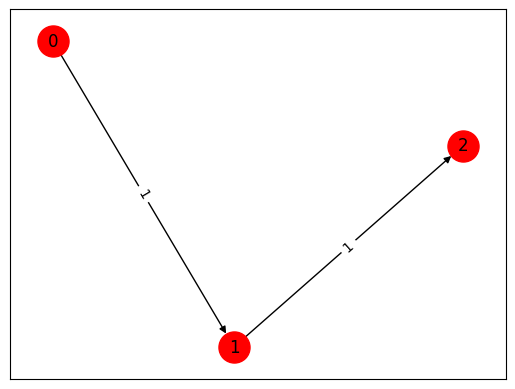

In [19]:
M2 = gb.Matrix.from_coo(
    [0, 1],
    [1, 2],
    [1, 1],
    nrows=3,
    ncols=3
)
gb.viz.draw(M2)

**1. (0, [0, 1, 2]):**

*Для стартовой вершины 0:*

- Вершина 0: начальная вершина, уровень 0.
- Вершина 1: достигается из вершины 0 за 1 шаг.
- Вершина 2: достигается из вершины 0 через вершину 1 за 2 шага.

**2. (1, [-1, 0, 1]):**

*Для стартовой вершины 1:*

- Вершина 0: недостижима из вершины 1, уровень -1.
- Вершина 1: начальная вершина, уровень 0.
- Вершина 2: достигается из вершины 1 за 1 шаг.

**3. (2, [-1, -1, 0]):**

*Для стартовой вершины 2:*

- Вершина 0: недостижима из вершины 2, уровень -1.
- Вершина 1: недостижима из вершины 2, уровень -1.
- Вершина 2: начальная вершина, уровень 0.

In [ ]:
results = msbfs_levels(M2, np.array([0, 1, 2]))
print(results)

[(0, [0, 1, 2]), (1, [-1, 0, 1]), (2, [-1, -1, 0])]


**1. (0, [-1, 0, 1]):**

*Для стартовой вершины 0:*

- Вершина 0: начальная вершина, нет родителя (-1).
- Вершина 1: достигается из вершины 0 (родитель 0).
- Вершина 2: достигается из вершины 1 (родитель 1).

**2.(1, [-2, -1, 1]):**

*Для стартовой вершины 1: *
- Вершина 0: недостижима из вершины 1 (-2).
- Вершина 1: начальная вершина, нет родителя (-1).
- Вершина 2: достигается из вершины 1 (родитель 1).

**3. (2, [-2, -2, -1]):**

*Для стартовой вершины 2:*
- Вершина 0: недостижима из вершины 2 (-2).
- Вершина 1: недостижима из вершины 2 (-2).
- Вершина 2: начальная вершина, нет родителя (-1).

In [ ]:
results = msbfs_parents(M2, np.array([0, 1, 2]))
print(results)

[(0, [-1, 0, 1]), (1, [-2, -1, 1]), (2, [-2, -2, -1])]


4. Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате `Matrix Market` с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.

Processed /content/mycielskian9.mtx with 383 vertices.
Processed /content/G1.mtx with 800 vertices.
Processed /content/G44.mtx with 1000 vertices.
Processed /content/mycielskian11.mtx with 1535 vertices.
Processed /content/G36.mtx with 2000 vertices.
Processed /content/EX4.mtx with 2600 vertices.
Processed /content/G49.mtx with 3000 vertices.
Processed /content/delaunay_n12.mtx with 4096 vertices.
Processed /content/fxm3_6.mtx with 5026 vertices.
Processed /content/G63.mtx with 7000 vertices.


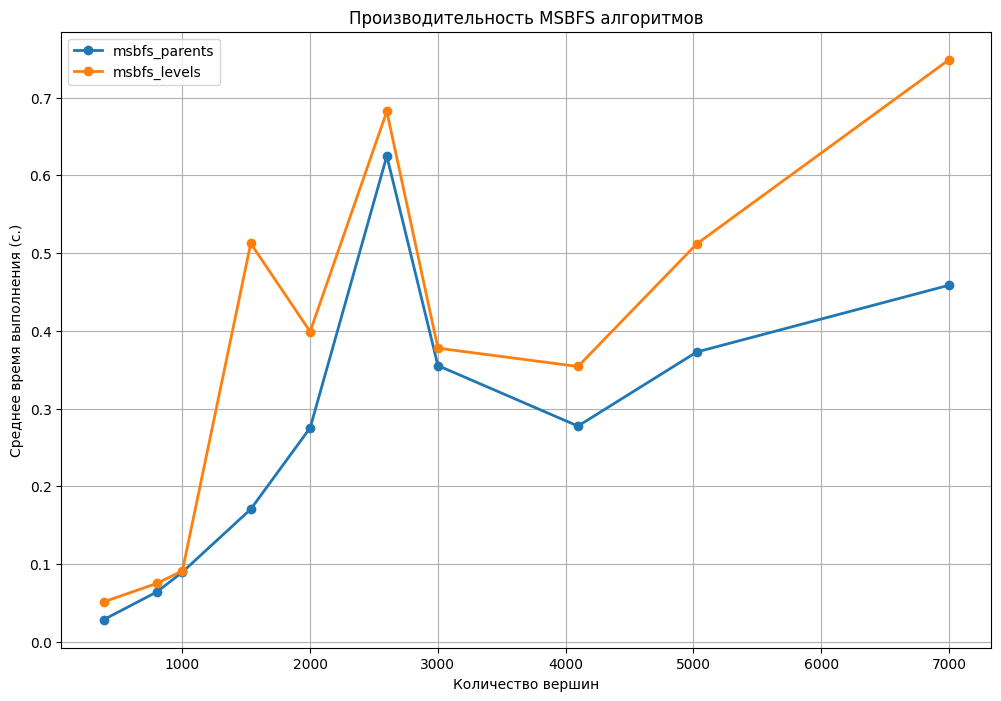

In [ ]:
import matplotlib.pyplot as plt
import timeit

files = [
    '/content/mycielskian9.mtx',
    '/content/G1.mtx',
    '/content/G44.mtx',
    '/content/mycielskian11.mtx',
    '/content/G36.mtx',
    '/content/EX4.mtx',
    '/content/G49.mtx',
    '/content/delaunay_n12.mtx',
    '/content/fxm3_6.mtx',
    '/content/G63.mtx'
]

def test_performance(A, start_vertices):
    functions = [msbfs_parents, msbfs_levels]
    times = {}
    for func in functions:
        t = timeit.timeit(lambda: func(A, start_vertices), number=10)
        times[func.__name__] = t / 10  # Среднее время выполнения
    return times

# Словарь для хранения данных времени выполнения
times_data = {func.__name__: [] for func in [msbfs_parents, msbfs_levels]}
vertex_counts = []

# Тестирование на реальных графах из файлов
for file_path in files:
    A = mmread(file_path)
    num_vertices = A.nrows
    start_vertices = [0, 1]
    vertex_counts.append(num_vertices)
    times = test_performance(A, start_vertices)
    for name, time in times.items():
        times_data[name].append(time)
    print(f"Processed {file_path} with {num_vertices} vertices.")

# Построение графика
plt.figure(figsize=(12, 8))
for name, times in times_data.items():
    plt.plot(vertex_counts, times, label=name, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Количество вершин')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность MSBFS алгоритмов')
plt.legend()
plt.grid(True)
plt.show()

**Выводы:**
- С увеличением количества вершин время выполнения обоих алгоритмов увеличивается;
- Алгоритм `msbfs_parents` в среднем работает быстрее, чем `msbfs_levels`, особенно на графах больших размеров;

- Скачки на графике указывают на то, что время выполнения зависит не только от количества вершин, но и от структуры графа и степени его разреженности.

In [ ]:
times_data = {func.__name__: {i: [] for i in range(1, 11)} for func in [msbfs_parents, msbfs_levels]}
graph_sizes = []

# Тестирование на реальных графах из файлов
for file_path in files:
    A = mmread(file_path)
    num_vertices = A.nrows
    graph_sizes.append(num_vertices)
    for num_start_vertices in range(1, 11):
        start_vertices = list(range(num_start_vertices))  # Используем от 1 до 10 стартовых вершин
        times = test_performance(A, start_vertices)
        for name, time in times.items():
            times_data[name][num_start_vertices].append(time)
        print(f"Processed {file_path} with {num_vertices} vertices and {num_start_vertices} start vertices.")

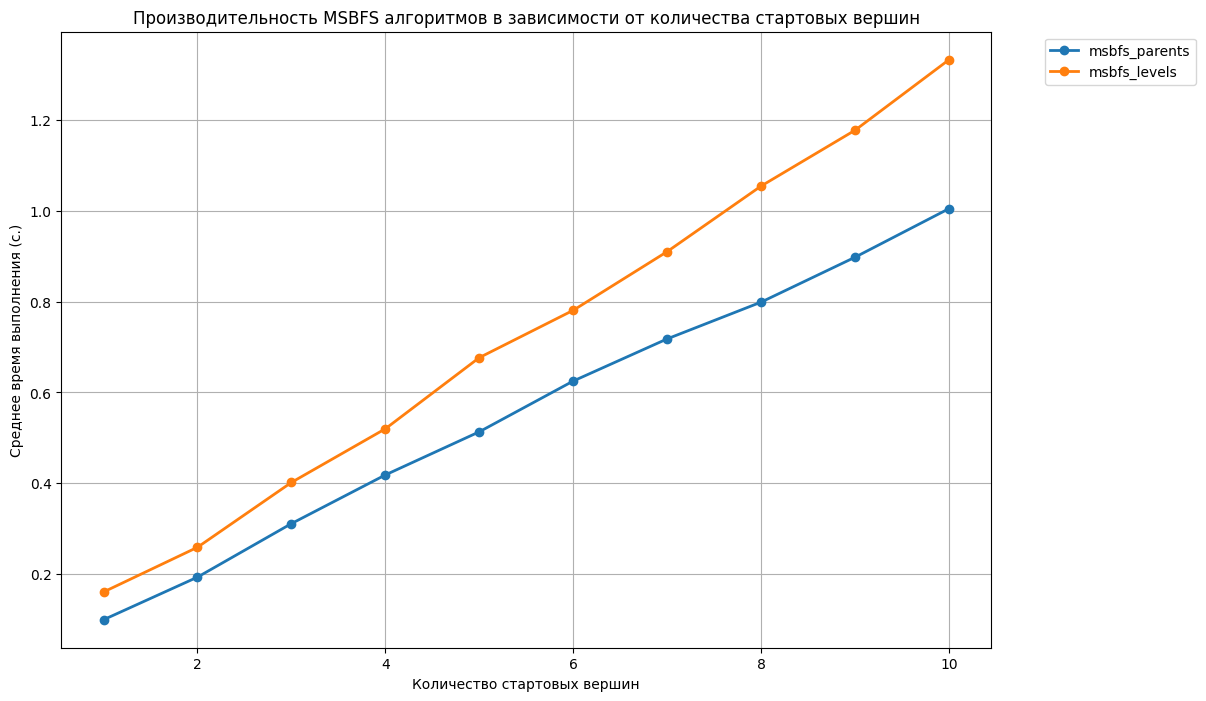

In [ ]:
plt.figure(figsize=(12, 8))
for name in times_data.keys():
    avg_times = [sum(times_data[name][i]) / len(times_data[name][i]) for i in range(1, 11)]
    plt.plot(range(1, 11), avg_times, label=name, marker='o', linestyle='-', linewidth=2)

plt.xlabel('Количество стартовых вершин')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность MSBFS алгоритмов в зависимости от количества стартовых вершин')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

**Выводы:**
- Оба алгоритма демонстрируют линейную зависимость времени выполнения от количества стартовых вершин. Это означает, что время выполнения увеличивается пропорционально количеству стартовых вершин;
- По мере увеличения количества стартовых вершин, разница в производительности между алгоритмами становится более заметной. `msbfs_levels` показывает более резкий рост времени выполнения по сравнению с `msbfs_parents`.

In [ ]:
import random

def generate_random_graph(num_vertices, num_edges):
    # Создаем пустые списки для хранения индексов и значений ребер
    indices_from = []
    indices_to = []
    values = []

    # Генерируем случайные ребра
    edges_added = 0
    while edges_added < num_edges:
        # Генерируем случайную пару вершин
        vertex1 = random.randint(0, num_vertices - 1)
        vertex2 = random.randint(0, num_vertices - 1)

        # Проверяем, что вершины различны и ребро еще не добавлено
        if vertex1 != vertex2 and (vertex1, vertex2) not in zip(indices_from, indices_to):
            # Добавляем индексы вершин и их симметричные пары
            indices_from.append(vertex1)
            indices_to.append(vertex2)
            indices_from.append(vertex2)
            indices_to.append(vertex1)
            # Добавляем значения ребер
            values.extend([1, 1])
            edges_added += 1
    # Создаем COO матрицу из списков индексов и значений
    coo_matrix = gb.Matrix.from_coo(indices_from, indices_to, values, nrows=num_vertices, ncols=num_vertices)
    return coo_matrix

Processed graph with 1000 vertices, sparsity 1%.
Processed graph with 1000 vertices, sparsity 5%.
Processed graph with 1000 vertices, sparsity 10%.
Processed graph with 1000 vertices, sparsity 20%.
Processed graph with 1000 vertices, sparsity 30%.
Processed graph with 1000 vertices, sparsity 40%.
Processed graph with 1000 vertices, sparsity 50%.


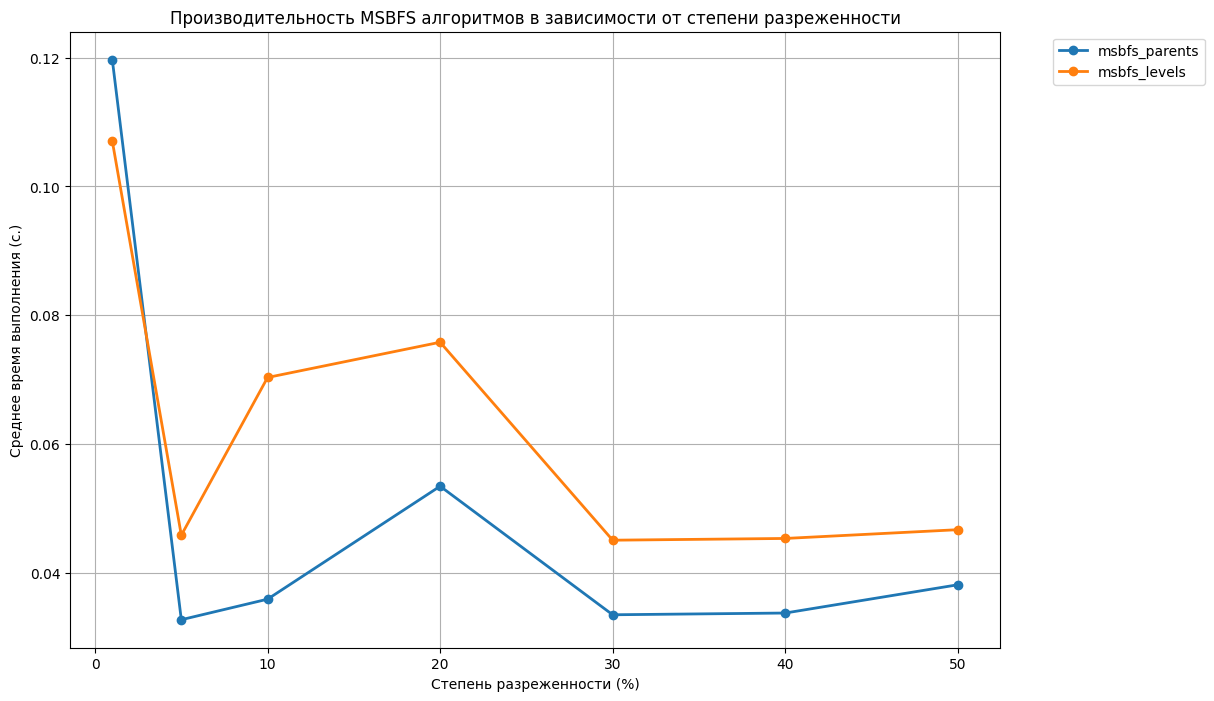

In [ ]:
sparsity_levels = [1, 5, 10, 20, 30, 40, 50]
times_data = {func.__name__: {s: [] for s in sparsity_levels} for func in [msbfs_parents, msbfs_levels]}
graph_sizes = []

# Зависимость времени работы от степени разреженности
num_vertices = 1000
start_vertices = [0]  # Одна стартовая вершина

for sparsity in sparsity_levels:
    num_edges = int((sparsity / 100) * num_vertices * (num_vertices - 1) / 2)
    A = generate_random_graph(num_vertices, num_edges)
    times = test_performance(A, start_vertices)
    for name, time in times.items():
        times_data[name][sparsity].append(time)
    print(f"Processed graph with {num_vertices} vertices, sparsity {sparsity}%.")

# Построение графика
plt.figure(figsize=(12, 8))
for name in times_data.keys():
    avg_times = [sum(times_data[name][s]) / len(times_data[name][s]) for s in sparsity_levels]
    plt.plot(sparsity_levels, avg_times, label=name, marker='o', linestyle='-', linewidth=2)

plt.xlabel('Степень разреженности (%)')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность MSBFS алгоритмов в зависимости от степени разреженности')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

**Выводы:**
- В начале графика видно, что для графов с очень высокой разреженностью (1%), время выполнения обоих алгоритмов достаточно высоко;
- Алгоритм `msbfs_parents` показывает лучшее время выполнения по сравнению с `msbfs_levels` на всех уровнях разреженности;
- В диапазоне разреженности от 40% до 50% время выполнения обоих алгоритмов остается достаточно стабильным и не показывает значительных изменений.

5. Добавить реализации описанных алгоритмов с использованием других полуколец (`any.pair` для `levels` и `any.first` для `parents`). Добавить тесты для проверки корректности. Провести экспериментальное исследование со сравнением этих реализаций с первоначальными на различных графах.

In [11]:
def msbfs_levels_any_pairs(graph: Matrix, start_vertices: list):
    # Количества вершин в графе
    num_vertices = graph.nrows
    # Создание матрицы для хранения уровней
    levels_matrix = Matrix(int, len(start_vertices), num_vertices)
    # Создание матрицы для отслеживания текущего фронтира
    frontier = Matrix(int, len(start_vertices), num_vertices)

    # Инициализация фронтира для каждой стартовой вершины
    for idx, start_vertex in enumerate(start_vertices):
        frontier[idx, start_vertex] = True

    # Создание вектора для отслеживания активных фронтиров
    active = Vector(bool, len(start_vertices))
    # Установка начального уровня
    current_level = 0

    while True:
        # Присвоение текущего уровня фронтиру
        levels_matrix(frontier.V) << current_level
        # Обновление фронтира с использованием матрично-векторного умножения и исключение уже посещенных вершин
        frontier(~levels_matrix.S, replace=True) << frontier.mxm(graph, semiring.any_pair)
        # Объединение всех фронтиров для проверки активности
        active << frontier.reduce_rowwise(monoid.lor)
        current_level += 1
        if active.nvals == 0:
            break

    results = []
    for i, start_vertex in enumerate(start_vertices):
        # Инициализация списка уровней значением -1 для всех вершин
        levels = [-1] * num_vertices
        # Для каждой вершины в графе
        for j in range(num_vertices):
          # Получаем уровень из матрицы уровней
            value = levels_matrix[i, j].value
            # Если уровень существует или это стартовая вершина
            if value is not None or j == start_vertex:
                # Присвоение уровня, если вершина достижима
                levels[j] = value if value is not None else 0
        # Добавление результатов для каждой стартовой вершины в список
        results.append((start_vertex, levels))

    return results

In [17]:
def msbfs_parents_any_first(graph: Matrix, start_vertices: list):
    # Получение количества вершин в графе
    num_vertices = graph.nrows
    # Вектор индексов вершин
    vertex_indices = Vector(dtypes.UINT64, num_vertices)
    # Построение индекса вершин
    vertex_indices.build(range(num_vertices), range(num_vertices))
    # Список для хранения результатов
    results = []

    for start_vertex in start_vertices:
        # Вектор для хранения родителей вершин
        parents = Vector(dtypes.INT64, num_vertices)
        # Установка родителя начальной вершины в -1
        parents[start_vertex] = -1
        # Вектор для текущего фронтира
        current_frontier = Vector(dtypes.INT64, num_vertices)
        # Инициализация фронтира начальной вершиной
        current_frontier[start_vertex] = 1

        while current_frontier.nvals > 0:
            # Обновление фронтира с индексами вершин
            current_frontier << vertex_indices.ewise_mult(current_frontier, binary.first)
            # Обновление фронтира и исключение посещенных вершин
            current_frontier(~parents.S, replace=True) << current_frontier.vxm(graph, semiring.any_first)
            # Обновление родителей вершин
            parents(binary.plus) << current_frontier

        # Формирование списка родителей для текущей стартовой вершины
        parents_list = [parents.get(i, default=-2) for i in range(num_vertices)]
        # Добавление результатов в список
        results.append((start_vertex, parents_list))
    return results

Проверим на тех же двух тестах корректность работы алгоритмов:

In [13]:
results = msbfs_levels_any_pairs(M1, np.array([0, 1, 2]))
print(results)

[(0, [0, 1, 1]), (1, [1, 0, 1]), (2, [1, 1, 0])]


In [18]:
results = msbfs_parents_any_first(M1, np.array([0, 1, 2]))
print(results)

[(0, [-1, 0, 0]), (1, [1, -1, 1]), (2, [2, 2, -1])]


In [20]:
results = msbfs_levels_any_pairs(M2, np.array([0, 1, 2]))
print(results)

[(0, [0, 1, 2]), (1, [-1, 0, 1]), (2, [-1, -1, 0])]


In [21]:
results = msbfs_parents_any_first(M2, np.array([0, 1, 2]))
print(results)

[(0, [-1, 0, 1]), (1, [-2, -1, 1]), (2, [-2, -2, -1])]


**Выводы:** видим, что получили те же самые ответы, полученные с использованием разных полуколец.

Processed graph with 1000 vertices, sparsity 1%.
Processed graph with 1000 vertices, sparsity 5%.
Processed graph with 1000 vertices, sparsity 10%.
Processed graph with 1000 vertices, sparsity 20%.
Processed graph with 1000 vertices, sparsity 30%.
Processed graph with 1000 vertices, sparsity 40%.
Processed graph with 1000 vertices, sparsity 50%.


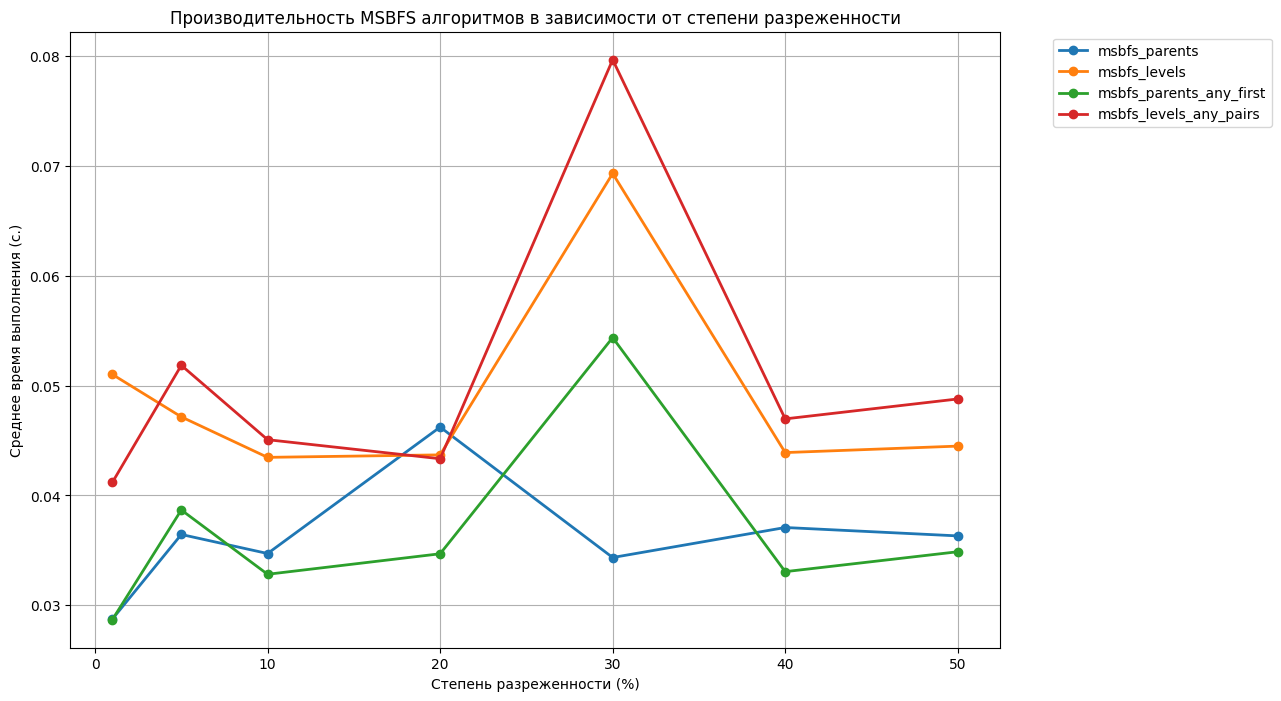

In [30]:
def test_performance(A, start_vertices):
    functions = [
        msbfs_parents, msbfs_levels,
        msbfs_parents_any_first, msbfs_levels_any_pairs
    ]
    times = {}
    for func in functions:
        t = timeit.timeit(lambda: func(A, start_vertices), number=10)
        times[func.__name__] = t / 10  # Среднее время выполнения
    return times

# Словарь для хранения данных времени выполнения
sparsity_levels = [1, 5, 10, 20, 30, 40, 50]
times_data = {func.__name__: {s: [] for s in sparsity_levels} for func in [
    msbfs_parents, msbfs_levels, msbfs_parents_any_first, msbfs_levels_any_pairs
]}

# Зависимость времени работы от степени разреженности
num_vertices = 1000
start_vertices = [0]  # Одна стартовая вершина

for sparsity in sparsity_levels:
    num_edges = int((sparsity / 1000) * num_vertices * (num_vertices - 1) / 2)
    A = generate_random_graph(num_vertices, num_edges)
    times = test_performance(A, start_vertices)
    for name, time in times.items():
        times_data[name][sparsity].append(time)
    print(f"Processed graph with {num_vertices} vertices, sparsity {sparsity}%.")

# Построение графика
plt.figure(figsize=(12, 8))
for name in times_data.keys():
    avg_times = [
        sum(times_data[name][s]) / len(times_data[name][s]) if len(times_data[name][s]) > 0 else 0
        for s in sparsity_levels
    ]
    plt.plot(sparsity_levels, avg_times, label=name, marker='o', linestyle='-', linewidth=2)

plt.xlabel('Степень разреженности (%)')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность MSBFS алгоритмов в зависимости от степени разреженности')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

**Выводы:**
- Для низкой и средней степени разреженности рекомендуется использовать `msbfs_parents` или `msbfs_parents_any_first`, так как они показывают лучшее время выполнения и стабильность.
- Для высокой степени разреженности `msbfs_parents` остается наиболее эффективным вариантом благодаря своей стабильной производительности.
- Использование полукольца `any_first`  не дало значительных преимуществ по сравнению с оригинальным алгоритмом `msbfs_parents`.
- Использование полукольца `any_pair` не рекомендуется для задач с высокой степенью разреженности из-за значительного увеличения времени выполнения.